__Group 20__:
- __Inês Rocha 20220052@novaims.unl.pt__
- __Pedro Ferreira 20220589@novaims.unl.pt__
- __Quintino Fernandes 20220634@novaims.unl.pt__

_Dataset_: https://drive.google.com/drive/folders/1NJOCRQ3ynA4BEOvWj5Ypr6iwi108LfOh?usp=share_link

(This is the non-zipped version, so one can see the images themselves. For the notebook, we use a zipped version, whose link is in the cell where the folder is imported. This is the dataset that we import to the model notebook, so it already has transformations that are made in preprocessing).

_References:_
1. [Algorithms for Skin Cancer Classification from Dermoscopic Images (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8945332/)
2. [Skin Cancer Classification from Dermoscopic Images: A Systematic Review (2022)](https://www.mdpi.com/1999-4893/15/11/438)
3. [Skin Cancer Classification: A Systematic Review (2022)](https://www.frontiersin.org/articles/10.3389/fonc.2022.893972/full)
4.[KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)

**Summary**:

In this notebook we:

- With keras' api we built the model to prepare it to do automatic hyperparameter tuning;

- Then, we used keras tuner to use Random Search to tune the model, which goes through a parameter space, using them randomly in the model and checking the validation scores to determine which combination of parameters is the best.

# 1. Import the dataset

In this section we upload our dataset to the workbook filesystem and split our data into **train**, **test** and **validation** sets.

We begin by installing and importing the necessary libraries

In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 7.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras
import keras_tuner
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from keras.engine.training import optimizer

import os
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split

import gdown

We upload the zip file with our Skin Cancer dataset.

In [3]:
url = 'https://drive.google.com/uc?id=1tQsRxytmTgUW3zV5VjYoOw467-23mZ1H'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1tQsRxytmTgUW3zV5VjYoOw467-23mZ1H
To: /content/data.zip
100%|██████████| 698M/698M [00:07<00:00, 89.3MB/s]


'data.zip'

In this cell we extract the files from the data.zip file and loading into this workbook filesystem. 

In [4]:
zip_ = zipfile.ZipFile('data.zip')
zip_.extractall()
zip_.close()
path = ""

After extracting all of the files, we define the paths for our train, test and validation folders.

In [5]:
training_folder, val_folder, testing_folder = "/content/transformed_data/transformed_train/", \
"/content/transformed_data/transformed_val/", "/content/transformed_data/transformed_test/"

For the sake of ensuring that the data isn't continuously duplicated, we created this boolean flag for the function created bellow. 

In [6]:
#Meter em True só na primeira vez
run = True

The **function make__copies()**, receives a folders and copies each photo n times and then stores it in the same folder. We will use this function as way to balance the dataset.

In [7]:
def make_n_copies(folder, n_copies):

# Loop through each file in the images folder
  for image in os.listdir(folder):
    file_path = os.path.join(folder, image)
    # Create n_copies of the file
    for i in range(n_copies):
      new_filename = f"{image.split('.')[0]}_copy{i+1}.jpg"
      new_file_path = os.path.join(folder, new_filename)
      shutil.copy(file_path, new_file_path)

if run:
  make_n_copies(training_folder + 'akiec', 18)
  make_n_copies(training_folder + 'bcc', 11)
  make_n_copies(training_folder + 'bkl', 5)
  make_n_copies(training_folder + 'df', 51)
  make_n_copies(training_folder + 'mel', 5)
  make_n_copies(training_folder + 'vasc', 42)     


We used the fuction **make_n_copies()**,to populate the target folders in all folders except **nv**, because it had significantly more records than the others.

Here we define the main parameters to import the images from the directory to a tf dataset.

In [8]:
image_size=(128,128)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

We defined the **image size** for our dataset to be **128x128 pixels**, because its a standart measure for iamges and so that images with diferent shapes dont conflict with our models. 

Our label mode is **categorical**, since our optimization problem is to predict which type of skin cancer is present in an image.

In this next cell, we generate our 3 tf datasets to train and test our model, with the parameters that we defined in the cell above.

In [9]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode, 
                                                shuffle=shuffle,
                                                seed=seed)

ds_val = image_dataset_from_directory(val_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

ds_test = image_dataset_from_directory(testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 30185 files belonging to 7 classes.
Found 1703 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.


After the creation of the ds_train/test/val datasets we can confirm that the function read all the files for each folder.


Here we print the class name of the ds_train to confim that we have all the target labels.

In [10]:
print(ds_train.class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


Legend of what exactly the target names stand for:
- "akiec": actinic keratoses and intraepithelial carcinoma / Bowen's disease
- "bcc": basal cell carcinoma
- "bkl": benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)
- "df": dermatofibroma
- "mel": melanoma
- "nv": melanocytic nevi
- "vasc": vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)


# 1. Model definition

First of all, we need to define some things prior to starting the models. Below we iterate in our training, particularly to get the input shape automatically.

In [11]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
input_shape = tuple(batch_x_train.shape)

The function below is based on the procedure of our deep learning classes. We input the model, learning rate and nr of epochs and it will give us a print of each epoch's measures. We added the precision and recall to the accuracy and AUC because we have an unbalanced set and even having oversampled the training set, we kept the other two sets unbalanced, because we thought it would simulate better real life.

The function will also return the history callbacks of the model, so we can later use them to compare models. We also added the f1score to the history dataframe we are outputing, using the precision and recall, because it is a good measure of quality of a model with imbalanced data.

In [38]:
def compilation(cnn, epochs = 10, optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)):
  cnn.compile(loss="categorical_crossentropy", 
              optimizer=optimizer,  
              metrics=[
                       metrics.AUC(name='AUROC'),
                       metrics.CategoricalAccuracy(name='accuracy'),
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall')])
  
  history = cnn.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1)
  # 3. 
  df_hist = pd.DataFrame.from_dict(history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  #calculating the f1score for each epoch (train and validation)
  df_hist['f1'] = 2*(df_hist['precision']*df_hist['recall'])/(df_hist['precision'] + df_hist['recall'])
  df_hist['val_f1'] = 2*(df_hist['val_precision']*df_hist['val_recall'])/(df_hist['val_precision']+df_hist['val_recall'])
  
  return df_hist

The function below, also based on the classes, to plot the progress of the model through the epochs. Because of the imbalance, we decided it would be more important to plot the f1_score, while still keeping an eye on the accuracy, so the rest of the measures won't be seen in this plot, but will always be visible inside the model's history. The loss function will also always be present.

In [13]:
def plot_hist(df_hist):
  secondary_y = ["f1", "val_f1", "accuracy", "val_accuracy"] 

  ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                    secondary_y = secondary_y, 
                    kind="line", figsize=(6, 3), grid=True, legend=True,
                    ylabel="Categorical cross-entropy", 
                    xlabel="Epoch", title="Learning curves", 
                    style=[".--", ".-"]*3,
                    color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                          alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("F1 Score and Accuracy")
  ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
  ax.right_ax.set_ylim(0.45, 1.05)
  ax.legend(loc=(1.15, 0.40), framealpha=1.0)
  plt.show()

As mentioned in the previous notebook, our base model's architecture would be the ResNet so now we define again the Bottleneck block classes, based on keras models. 

In [14]:
class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x

# Hyperparameter search

## Building the model

Here we define the architecture of one of our best models and we define the fuction **build_model()**, based on the Keras API Reference. Bellow we will check which parameters are better for the:


*   Activation function
*   Learning Rate
* Weight Decay
* Optimizer



In [21]:
def build_model(hp):
    inputs = layers.Input(shape=input_shape[1:])
    x = layers.BatchNormalization()(inputs)
    # Conv1
    x = layers.Conv2D(filters=128, kernel_size=7, strides=2, padding='same',
                                      kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
    # BN1
    x = layers.BatchNormalization()(x)
    # ReLU
    x = layers.Activation(hp.Choice("activation",["relu", "tanh","elu", "selu"]))(x)
    # MP
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    # BB
    x = BottleneckBlock(256, squeeze=1, expand=2, downsample=True, seed=seed)(x)
    # GMP
    x = layers.GlobalMaxPooling2D()(x)
    # Dense1
    y_pred = layers.Dense(units=7, activation="softmax", 
                                      kernel_initializer=initializers.GlorotNormal(seed=seed))(x)

    model = keras.Model(inputs, y_pred)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="linear")
    wd = hp.Float(name="wd",min_value = 0,max_value=0.01,step=0.002)
    optimizer = hp.Choice("optimizer", ['SGD', 'adam', 'RMSprop'])
    optimizer_dict = {
        'SGD': keras.optimizers.SGD,
        'adam': keras.optimizers.Adam,
        'RMSprop': keras.optimizers.RMSprop,
    }

    optimizer_obj = optimizer_dict[optimizer]
    model.compile(
        optimizer=optimizer_obj(learning_rate=lr, decay=wd),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(keras_tuner.HyperParameters())


This function returned the built modeland its now ready to undergo on the Random Search.

## Random Search

Here we define our keras tuner that will do 10 trial and will do 2 executions per trial. Our objetive is to maximize the models val_accuracy without underfitting it.

In [22]:
hp = keras_tuner.HyperParameters()

In [23]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials= 2,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="skinCancer",
)

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
wd (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.01, 'step': 0.002, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'SGD', 'conditions': [], 'values': ['SGD', 'adam', 'RMSprop'], 'ordered': False}


**tuner.search_space_summary()** function sumarizes and prints out, our models search space.

The function **tuner.search()** will train our model multiple times with different parameters randomly appointed. 
In this case we opted for: 

*   10 Trials
*   2 Executions per trial
*   10 Epochs per Execution



In [ ]:
tuner.search(ds_train, epochs=10, validation_data=(ds_val))


Trial 10 Complete [00h 24m 57s]
val_accuracy: 0.7856723368167877

Best val_accuracy So Far: 0.7956547141075134
Total elapsed time: 04h 20m 06s


Unfortunately, google colab's gpu runtime interrupted and we could not salvage the summary of the bigger random search.

The function **tuner.search()** will train our model multiple times with different parameters randomly appointed. 
In this case we opted for: 

*   2 Trials
*   1 Executions per trial
*   10 Epochs per Execution



In [25]:
tuner.search(ds_train, epochs=10, validation_data=(ds_val))
tuner.results_summary()

Trial 2 Complete [00h 12m 43s]
val_accuracy: 0.7944803237915039

Best val_accuracy So Far: 0.7944803237915039
Total elapsed time: 00h 25m 24s
Results summary
Results in my_dir/skinCancer
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
activation: relu
lr: 0.005092414208114357
wd: 0.01
optimizer: RMSprop
Score: 0.7944803237915039

Trial 0 summary
Hyperparameters:
activation: tanh
lr: 0.00010271267758991986
wd: 0.004
optimizer: RMSprop
Score: 0.7604227662086487


We can see that RMSprop was the best in both trials. The best trial was Trial 1, although this was a small search because of time and google's runtime concerns, so with a bigger search we probably would have better results.

In this next cell we save our models and print out ths summary of the best one.

In [40]:
models = tuner.get_best_models(num_models=2)
bm = models[0]

#Here we build our best model to later compile it and compare with
bm.build(input_shape=(3, 128, 128))
bm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       18944     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 64, 64, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 128)      0     

As we can see, the architecture of the model is the same as the one we input into random search.

# Model Comparison

In [41]:
hyper_model = compilation(bm, 15, tf.keras.optimizers.RMSprop(learning_rate = 0.005092414208114357))

Epoch 1/15
472/472 [==============================] - 76s 153ms/step - loss: 1.1526 - AUROC: 0.8984 - accuracy: 0.5959 - precision: 0.7074 - recall: 0.4669 - val_loss: 0.8395 - val_AUROC: 0.9423 - val_accuracy: 0.6994 - val_precision: 0.7735 - val_recall: 0.6277
Epoch 2/15
472/472 [==============================] - 72s 150ms/step - loss: 0.6591 - AUROC: 0.9631 - accuracy: 0.7564 - precision: 0.8120 - recall: 0.6949 - val_loss: 1.0088 - val_AUROC: 0.9341 - val_accuracy: 0.6512 - val_precision: 0.6814 - val_recall: 0.6166
Epoch 3/15
472/472 [==============================] - 72s 151ms/step - loss: 0.4687 - AUROC: 0.9804 - accuracy: 0.8276 - precision: 0.8619 - recall: 0.7954 - val_loss: 0.9656 - val_AUROC: 0.9408 - val_accuracy: 0.6988 - val_precision: 0.7207 - val_recall: 0.6712
Epoch 4/15
472/472 [==============================] - 72s 151ms/step - loss: 0.3708 - AUROC: 0.9868 - accuracy: 0.8661 - precision: 0.8878 - recall: 0.8458 - val_loss: 2.0262 - val_AUROC: 0.8516 - val_accuracy: 

Below, let's see a comparison of the hyper parameter tuned model to the one we iteratively built before. On top is the learning curve for the former, below it is the one for the latter.

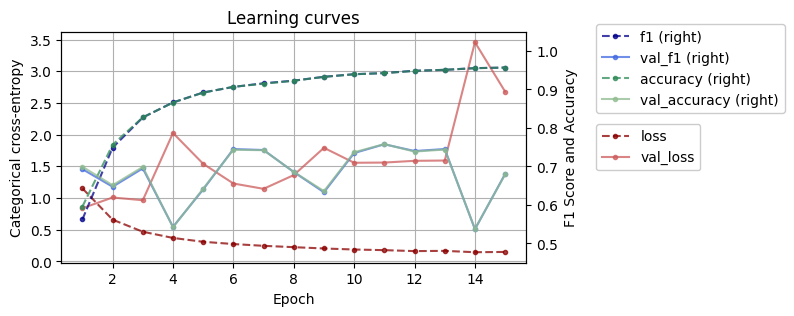

In [42]:
plot_hist(hyper_model)

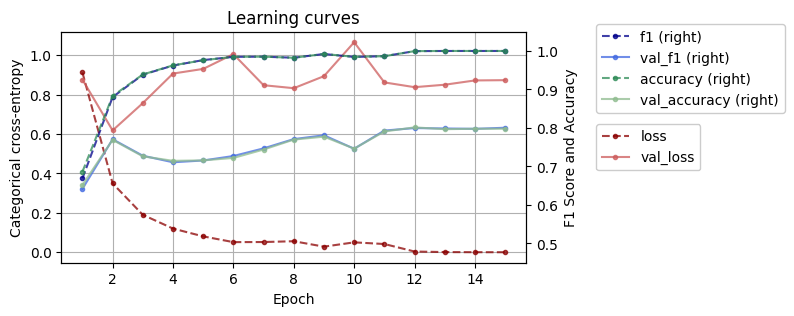

Unfortunately, the automatically tuned model did not reach the performance of the best model we got by handcrafting. The validation scores are lower for the f1 score and accuracy. The loss function also did not seem to reach the lows of the one in our best model.

Now let's compare the models' main metrics, the f1 score and the accuracy. Just like before, on top are the metrics for the hyper model.

In [45]:
test_scores_hyper = bm.evaluate(ds_test,verbose = 0)

print(f'Test Accuracy: {test_scores_hyper[2]}')

print(f'Test f1_score: {2*test_scores_hyper[-2]*test_scores_hyper[-1]/(test_scores_hyper[-2]+test_scores_hyper[-1])}')

Test Accuracy: 0.6679973602294922
Test f1_score: 0.6693413589374272


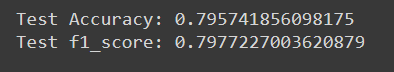

Our best handcrafted model outperformed this new one by a large margin. This is probably because we didn't manage to get a big hyperparameter automatic search because of runtime and time constraints. In spite of that, we ended up with a fairly good model, even if handcrafted, which reaches the scores of around 80%.